###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2021 Lorena A. Barba, Pi-Yueh Chuang, Tingyu Wang

# Logistic regression

In Lesson 1 of this module, you learned about fitting a line to data (linear regression) using the method of gradient descent to find the model parameters (slope and $y$-intercept). But what if the observational data looks nothing like it has a linear relationship?

A major class of problems deals with binary classification, that is, the data belong to one of two categories. 
Typically, we code the two categories with $0$ and $1$. For example, is an email spam, or not spam? Is a credit-card transaction fraudulent, or legitimate? 
In these settings, often the data correspond to numbers between $0$ and $1$ that represent some _probability_ (e.g., that the email be spam or not), and one applies a decision boundary to assign each item to a class.

One effective way to build a model representing this situation is logistic regression. The output of the model is a number between $0$ and $1$, for inputs in the whole real line. 
With binary data (zeros and ones), we might imagine that a good model could look like a step function. But this function is not differentiable. Since we want to use gradient descent, we adopt a continuous function that approximates the step function. 

## Logistic function

We can build a model that will output a value between zero and one by making a non-linear transformation of the linear regression. 
This is achieved with the _logistic function_:

$$ \sigma(z) = \frac{1}{1+e^{-z}}$$

With the data consisting of two arrays, $x, y$, the model is a composition: $z= wx + b$ and $\sigma(z)$ is the output.
The task is finding $w$ and $b$ so that $\sigma(z)$ is closest to $y$ for all data points.

Let's play with this function using SymPy. We'll need NumPy and Matplotlib later, so might as well load all our libraries now.

In [1]:
import sympy
import numpy

from matplotlib import pyplot
%matplotlib inline

In [2]:
z = sympy.Symbol('z', real=True)

logistic = 1/(1+ sympy.exp(-z))
logistic

1/(1 + exp(-z))

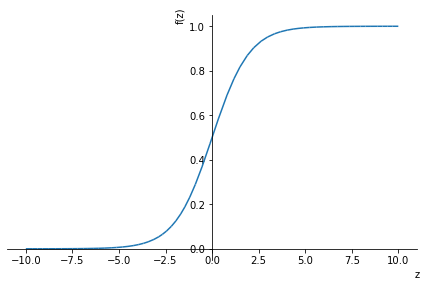

In [3]:
sympy.plotting.plot(logistic);

That's a well-groomed $S$-shaped function: it's called a _sigmoid_ curve. Notice that when $z=0$ it takes the value $0.5$, and it approaches zero on the left, and one on the right.

Let's generate some synthetic data to play with. (We take this example from the SciPy 2019 tutorial by Eric Ma [1]). 
Our goal is to use gradient descent to find the model parameters $w$ and $b$ that best fit the data, in some sense that we need to discover.

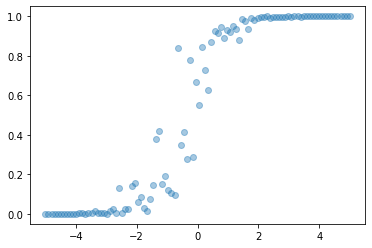

In [4]:
# synthetic data
x_data = numpy.linspace(-5, 5, 100)
w = 2
b = 1
numpy.random.seed(0)
z_data = w * x_data + b + numpy.random.normal(size=len(x_data))
y_data = 1 / (1+ numpy.exp(-z_data))

pyplot.scatter(x_data, y_data, alpha=0.4);

Above, we chose the parameters $w$ and $b$ for the model, and used them to get the intermediate variable $z$ adding some random noise to make our synthetic data look more "realistic."
The call to `numpy.random.seed()` makes our added noise reproducible, i.e., you always get the same pseudo-random numbers from the subsequent call to `numpy.random.normal()`. 
(Let's not get side-tracked into a discussion about pseudo-random number generation, and leave that for another tutorial.)

We can apply a decision boundary now to assign the data to the two classes. Be sure to read the documentation of [`numpy.where()`](https://numpy.org/doc/stable/reference/generated/numpy.where.html) to understand the code below, noting that after the logical condition we specify the values to assign if the condition is `True` or `False`.

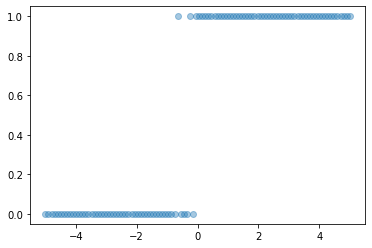

In [5]:
y_data = numpy.where(y_data >= 0.5, 1, 0)
pyplot.scatter(x_data, y_data, alpha=0.4);

## Logistic loss function

To use gradient descent, we need a loss function that we can optimize with respect to the parameters. 
If we were to use a mean-square-error loss function, like in linear regression, we'd run into a few problems. Let's discuss.

Taking the derivatives to optimize would involve $\sigma^{\prime}(z)$, so let's look at that.

In [6]:
lprime = logistic.diff(z)
lprime

exp(-z)/(1 + exp(-z))**2

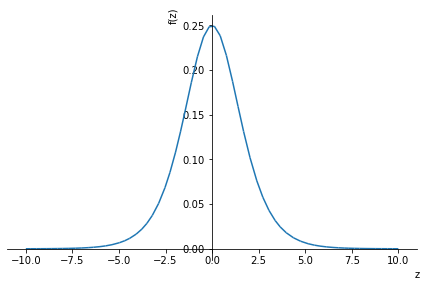

In [7]:
sympy.plotting.plot(lprime);

The derivative of the logistic function takes very small values at the long tails on each side of $z=0$. 
If our loss function has a $\sigma^{\prime}(z)$ factor (coming from the chain rule), this would lead to _slow learning_. 
We'd like to work with a better loss function, that avoids this problem, and we build one below by integration. (For a more detailed discussion, we recommend Chapter 3 of Michael Nielsen's free ebook [2]).

It's important to note also that our prediction model is a nonlinear function, composed with the linear model, and the square-error would lead to a non-convex loss function that can have local minima, and make gradient descent fail. 
Here's an example posted on Stackoverflow in answer to this very [question](https://math.stackexchange.com/questions/2381724/logistic-regression-when-can-the-cost-function-be-non-convex). Consider just three data points, and a model with no intercept, $z = wx$: $(-1, 2), (-20, -1), (-5, 5)$. What would a square-error loss function look like? We can plot it using SymPy.

In [8]:
badloss = (1/(1+ sympy.exp(-z))-2)**2 + \
          (1/(1+ sympy.exp(-20*z))+1)**2  + \
          (1/(1+ sympy.exp(-5*z))-5)**2
badloss

(-5 + 1/(1 + exp(-5*z)))**2 + (-2 + 1/(1 + exp(-z)))**2 + (1 + 1/(1 + exp(-20*z)))**2

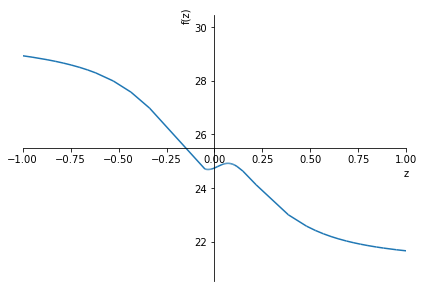

In [9]:
sympy.plotting.plot(badloss, xlim=(-1,1));

You can see a local minimum, where gradient descent could get stuck!

But let's go back to inspecting the derivative of the logistic function. 
We note that $\sigma^{\prime}(z)$ has the same expression in the denominator as $\sigma(z)$, but squared. Let's play around with this...

In [10]:
lprime/logistic

exp(-z)/(1 + exp(-z))

OK, we can try to express this in terms of $\sigma(z)$: add and subtract $1$ to the numerator and factor:

$$\frac{e^{-z}}{1+e^{-z}} = \frac{1+e^{-z}-1}{1+e^{-z}} = 1 - \frac{1}{1+ e^{-z}} = 1 - \sigma(z)$$

We get this interesting property for the derivative of the logistic function:

$$\sigma^{\prime}(z) = \sigma(z) (1-\sigma(z))$$

Following Nielsen [2], let's call $\sigma(z)=a$, representing the predicted value by the model where $z=wx +b$. 
The deviation between the model output and the observational data at each point is measured by $|y-a|$. 
A square-error loss function, as used for linear regression, is $(y-a)^2$, giving derivatives with respect to the parameters that are proportional to the error: 
the larger the error, the larger the step taken in gradient descent. 
That's a nice property.

Seeking a loss function $L$ with the same behavior, we would like, for example:
$\frac{\partial L}{\partial b} = (y-a)$. 
Using the chain rule,
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial a}\frac{\partial a}{\partial z} = \frac{\partial L}{\partial a} \sigma^{\prime}(z) = \frac{\partial L}{\partial a} \, a(1-a)$$

using the property of $\sigma^{\prime}$ in the last step.

Our desired behavior for $L$ is that this derivative be $(y-a)$, giving:

$$ \frac{\partial L}{\partial a} = \frac{(y-a)}{a(1-a)}$$


This lets us construct $L$ by integration:

In [11]:
a, y = sympy.symbols('a y', real=True)

In [12]:
dLda = (y-a)/a/(1-a)
dLda

(-a + y)/(a*(1 - a))

In [13]:
L = sympy.integrate(dLda, a)
L

y*log(a) + (1 - y)*log(a + (1 - 2*y)/(2*y - 1))

In [14]:
sympy.simplify(L)

y*log(a) - (y - 1)*log(a - 1)

(Plus a constant of integration.) We note that since $a<1$ (and the logarithm is only defined for positive real numbers) we need:

In [15]:
L = -y*sympy.log(a) + (y-1)*sympy.log(1-a)
L

-y*log(a) + (y - 1)*log(1 - a)

In [16]:
sympy.simplify(L.diff(a))

(-a + y)/(a*(a - 1))

The derivative is the same expression we started with. 
This is the _logistic loss function_ for a single data point:

$$L = -y \log(a) + (y-1) \log(1-a)$$

Let's inspect this loss function. If the true value is $y=1$, we get $L= -\log(a)$. 
Plotting in the range of interest shows that the gradient is largest when the model output is furthest away from the true value. 
This is a nice property.

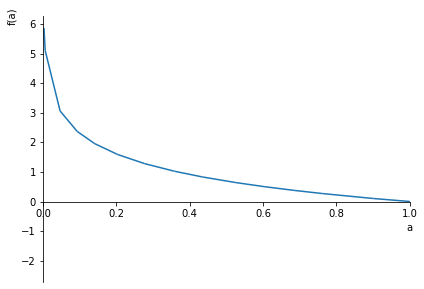

In [17]:
sympy.plotting.plot(-sympy.log(a), xlim=(0,1));

If $y=0$: $L= - \log(1-a)$. The plot again shows that the gradient is largest when the model output is furthest from the true value.

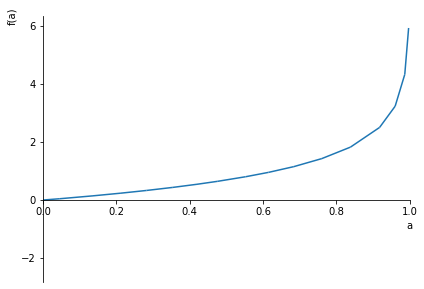

In [18]:
sympy.plotting.plot(-sympy.log(1-a), xlim=(0,1));

## Find the parameters using `autograd`

With the logistic loss function, we're ready to use gradient descent in an optimization loop. 
Above, we defined the `logistic` SymPy expression as a function of the symbol `z`, so let's re-define it to include the composition with $wx+b$. 
We could then define the loss function symbolically, as we did for linear regression; have a look at this:

In [19]:
logistic

1/(1 + exp(-z))

In [20]:
w, b, x, y = sympy.symbols('w b x y')
logistic = 1/(1+ sympy.exp(-w*x-b)) # redefined with the composition

Loss = -y*sympy.log(logistic) - (1-y)*sympy.log(1-logistic)
Loss

-y*log(1/(exp(-b - w*x) + 1)) - (1 - y)*log(1 - 1/(exp(-b - w*x) + 1))

So far, we can still use SymPy to get derivatives of the loss function with respect to the parameters. But with more complicated models, finding symbolic derivatives could take a long time.

Have a look at the derivative of the logistic loss with respect to the parameter $b$: 

In [21]:
Loss.diff(b)

-y*exp(-b - w*x)/(exp(-b - w*x) + 1) - (y - 1)*exp(-b - w*x)/((1 - 1/(exp(-b - w*x) + 1))*(exp(-b - w*x) + 1)**2)

Although we can use symbolic differentiation, we later need to convert the resulting expression to a Python function that can be called and evaluated at many data inputs. Maybe this is not the best approach.

There's a better way! It's called _automatic differentiation_: the idea is to algorithmically obtain derivatives of numeric functions written in computer code. 
It sounds like magic, but it can be done by a combination of the chain rule, symbolic rules of differentiation for elementary operations, and a numeric evaluation trace of the elementary derivatives. 

The details of how automatic differentiation works are fascinating, but here we skip ahead to say that software libraries are freely available to do this! 
For Python programs, the [`autograd`](https://github.com/hips/autograd) package was specifically developed for gradient-based optimization. 
It is described thus:

> Autograd can automatically differentiate native Python and NumPy code. It can handle a large subset of Python's features, including loops, ifs, recursion and closures, and it can even take derivatives of derivatives of derivatives.

(The package is no longer in active development, as a new version was folded into the [JAX](https://github.com/google/jax) project, out of Google. It is still maintained, though, and just as useful as ever!)

To install the package, you can run the following command (either on the terminal or in a Jupyter code cell):

```
pip install autograd
```

Or, if you installed your Python environment via [Anaconda](https://www.anaconda.com/products/individual), you can run this command:
```
conda install -c conda-forge autograd
```

Once the package is installed in your working environment, you can import it in the usual Pythonic way. 
The main function you will need is `autograd.grad()`, which takes a scalar-valued Python function as argument, and returns another function that evaluates to its derivative. 
It's what we use in the optimization loop to perform gradient descent.

In addition, `autograd.numpy` is a wrapper to the NumPy library. This allows you to call your favorite NumPy methods with `autograd` keeping track of every operation so it can give you the derivative (via the chain rule).

In [22]:
# import the autograd-wrapped version of numpy
from autograd import numpy

In [23]:
# import the gradient calculator
from autograd import grad  

It's important to realize that we now need to design our program in a _functional_ style: defining Python functions for the logistic and loss functions, so that we may apply `autograd.grad()` in the optimization loop. 
Study the code below.

In [24]:
# note: the namespace numpy is the autograd wrapper to NumPy

def logistic(z):
    '''The logistic function'''
    return 1 / (1 + numpy.exp(-z))
    
def logistic_model(params, x):
    '''A prediction model based on the logistic function composed with wx+b
    Arguments:
       params: array(w,b) of model parameters
       x :  array of x data'''
    w = params[0]
    b = params[1]
    z = w * x + b
    y = logistic(z)
    return y

def log_loss(params, model, x, y):
    '''The logistic loss function
    Arguments:
       params: array(w,b) of model parameters
       model:  the Python function for the logistic model
       x, y:   arrays of input data to the model'''
    y_pred = model(params, x)
    return -numpy.mean(y * numpy.log(y_pred) + (1-y) * numpy.log(1 - y_pred))

In [25]:
# get a function to compute the gradient of the logistic loss
gradient = grad(log_loss)

In [26]:
type(gradient)

function

##### Note:

> The argument list of the function returned by `grad()` will be the same as the argument list of the loss function that we input to it.
> The default setting of `grad()` is to return the derivative(s) with respect to the first argument, in this case, the two-element array `params`. This gives us the two derivatives (with respect to $w$ and $b$) at once.

Let's now make a random starting guess for the two model parameters:

In [27]:
numpy.random.seed(0)
params = numpy.random.rand(2)
print(params)

[0.5488135  0.71518937]


With values assigned to the two parameters, this is how you compute the corresponding derivatives—we'll need to do this in each iteration of the optimization loop:

In [28]:
gradient(params, logistic_model, x_data, y_data)

array([-0.42734877,  0.08274066])

Now we optimize! Notice that in this optimization loop we chose to use a `while` statement, instead of `for`. 
We set both a maximum number of iterations, and an exit criterion based on the norm of the gradient being very small.
Already you should be thinking about these choices we make:

- The gradient is multiplied by a small step of $0.01$: this is called the _learning rate_. How do we choose this value?
- The `while` loop exits when the norm of the gradient is $0.001$: how do we know if this is a good choice?

Finally, we plot the synthetic data we created above, and the logistic regression curve corresponding to the parameters found in the optimization loop.

Optimized value of w is 2.731 vs. true value: 2
Optimized value of b is 0.697 vs. true value: 1
Exited after 5000 iterations


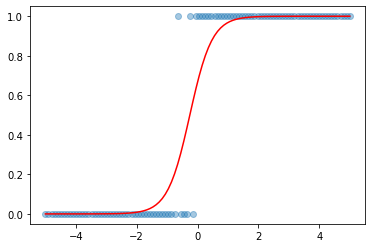

In [29]:
max_iter = 5000
i = 0
descent = numpy.ones(len(params))

while numpy.linalg.norm(descent) > 0.001 and i < max_iter:

    descent = gradient(params, logistic_model, x_data, y_data)
    params = params - descent * 0.01
    i += 1


print(f'Optimized value of w is {params[0]:.3f} vs. true value: 2')
print(f'Optimized value of b is {params[1]:.3f} vs. true value: 1')
print(f'Exited after {i} iterations')


pyplot.scatter(x_data, y_data, alpha=0.4)
pyplot.plot(x_data, logistic_model(params, x_data), '-r');

It worked! We found a logistic curve that approximates the data quite well. 
This curve represents the _prediction model_ for the continuous data between $0$ and $1$. 
In a classification task, the next step is to assign a decision threshold for the two classes; a natural choice is $0.5$.

In [30]:
def decision_boundary(y):
    return 1 if y >= .5 else 0

This function will code as $0$ or $1$ each data point. We will want to apply the function element-wise to all elements in an array, for which we can use [`numpy.vectorize()`](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html). 
Be sure to read the documentation of this very useful NumPy function that saves you from having to write a for-loop!

The decision rule is what turns logistic regression into a classification tool. Check it out!

In [31]:
decision_boundary = numpy.vectorize(decision_boundary)

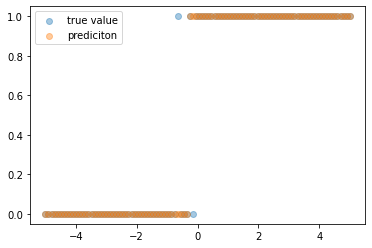

In [32]:
def classify(predictions):
    '''
    Argument:
    predictions, an array of values between 0 and 1
    
    Returns: 
    classified, an array of 0 and 1 values'''

    return decision_boundary(predictions).flatten()

pyplot.scatter(x_data, y_data, alpha=0.4,
               label='true value')
pyplot.scatter(x_data, classify(logistic_model(params, x_data)), alpha=0.4, 
               label='prediciton')

pyplot.legend();

And this is the end of Lesson 2 of our module. We spent some time deriving the logistic loss function, where most sources will just give it to you without explanation. 
We find it more satisfying this way, but you can certainly skip it. 

The key ingredients we have added in this lesson are the ideas of:
- using composition of functions in our model
- using automatic differentiation to get the gradients for the optimization loop

In the next lesson, we add the idea of multiple independent variables (a.k.a. _features_) affecting our model, leading to **multiple linear regression.**

## What we've learned

- The logistic function approximates a step function while being differentiable. That's nice.
- Logistic regression applies composition of the logistic function with a linear model.
- We can use logistic regression in binary classification problems.
- Using the square-error in this case leads to a non-convex loss function, with local minima.
- The logistic loss function is best here for optimizing with gradient descent.
- Automatic differentiation gives us derivatives of numeric functions written in computer code.
- We pick some values in the optimization loop that we need to be careful with (e.g., learning rate).

## References

1. Eric Ma, "Deep Learning Fundamentals: Forward Model, Differentiable Loss Function & Optimization," SciPy 2019 tutorial. [video on YouTube](https://youtu.be/JPBz7-UCqRo) and [archive on GitHub](https://github.com/ericmjl/dl-workshop/releases/tag/scipy2019).
2. Michael A. Nielsen, "Neural Networks and Deep Learning" (2015), Determination Press, http://neuralnetworksanddeeplearning.com

In [33]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())